In [1]:
import codecs
import json
import numpy as np
import sklearn

In [12]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('glove-wiki-gigaword-50')
#glove_300=Embeddings('glove-wiki-gigaword-300')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
#Getting the attributes of the embeddings 
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Cleaning the embeddings from puntuation and numbers
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 599553.73it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [7]:
from Scripts.HardDebias import *

In [8]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


In [9]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [10]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [13]:
#Function that changes the definitional sets dictionary into a dictionary per social category where an index is the key and the values are lists of definitional words  
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

## Evaluation of Vector Transformations

In [14]:
from Scripts.Visualization import *
from Scripts.Evaluation import *

### Setting up parameters and combinations

In [15]:
# Importing the dataset with all parameter combinations: 
# norm_direction is a parameter that determines whether the bias direction is normalized or not
# normalize is a parameter that determines whether the word vectors are normalized before or after debiasing
# centralize is a parameter that determines whether the word vectors are centered before using PCA to find the bias subspace
import pandas as pd
parameters = pd.read_csv('Data/all_parameter_combinations.csv', header=0)
parameters


norm_direction normalize  centralize
0            False      None       False
1            False      None        True
2            False     after       False
3            False     after        True
4            False    before       False
5            False    before        True
6             True      None       False
7             True      None        True
8             True     after       False
9             True     after        True
10            True    before       False
11            True    before        True

In [16]:
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']


In [17]:
# gets the debiased vectors for all the 12 possible scenarios and stores them on a dataframe
def get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                         vocab_cleaned,
                         equalizing_lists,
                         def_set, parameters_df):
    grand_dictionary = {}
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #run the hard_debias function with the parameters of the row and generate a dictionary with the results: key=index, value:dictionary, key=name (vectors, vocab, word2idx), value: the result of the function
        debiased_vectors, debiased_vocab, debiased_word2idx, debiased_dict= hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists, 
                             def_set,
                             1,
                             normalize_dir=parameters_df.iloc[i][0],
                             normalize=parameters_df.iloc[i][1],
                             centralizing=parameters_df.iloc[i][2])
       
        #add the variables to the grand dictionary
        grand_dictionary[i] = {'vectors': debiased_vectors, 'vocab':debiased_vocab, 'word2idx':debiased_word2idx, 'dict':debiased_dict}
                    
        
    return grand_dictionary

In [18]:
grand_dict=get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                     vocab_cleaned,
                     equalizing_lists['gender'],
                     def_set_gender, parameters)


Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


### Bias Pre-Post of selected words. 
Using the original and debiased vectors, I calculate bias scores in two ways: 
1. Simple Bias Score: cos(v, she_embed)-cos(v, he_embed) for every v in the vocabulary
2. Direct bias score: following Bolukbasi et al. 2016

With this, I get a measure of the debiasing effects per word or the chosen list. 

In [19]:
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)

def get_debiased_vectors_scores_plots(grand_dict,dict_vectors,vocab_cleaned,parameters_df,he_embed,she_embed):
    scores_dictionary = {}
    
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        #debiased_word2idx=grand_dict[i]['word2idx']
        debiased_dict = grand_dict[i]['dict']

        # Using the gender bias function to compute the bias of all the words in the limited dataset
        #We create a dictionary with the word as key and the bias as value
        gender_bias_after_debiasing= compute_gender_simple_bias(debiased_dict, he_embed, she_embed)
        
        gender_direction = identify_bias_subspace(dict_vectors, def_set_gender, 1, centralizing=parameters_df.iloc[i][2])
        if parameters_df.iloc[i][0]:
            gender_direction = utils.normalize(gender_direction)
        
        #use compute_direct_bias to get the scores
        direct_gender_bias_original = compute_direct_bias(
            dict_vectors, vocab_cleaned, gender_direction)
        direct_gender_bias_debiased= compute_direct_bias(debiased_dict, vocab_cleaned, gender_direction)
        
        scores_dictionary[i] = {'simple_bias': gender_bias_after_debiasing,
                                'direct_bias_original': direct_gender_bias_original, 
                                'direct_bias_debiased': direct_gender_bias_debiased}
    return scores_dictionary


In [20]:
scores_dictionary = get_debiased_vectors_scores_plots(
    grand_dict,dict_vectors,vocab_cleaned, parameters, he_embed, she_embed)


Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


In [21]:
#Function to get a bar plot comparing pre-post scores for chosen words
def getting_plots_simple_scores(grand_dict,test_words, gender_bias_original, scores_dictionary, parameters_df):
    for i in range(len(scores_dictionary)):
        debiased_vocab=grand_dict[i]['vocab']
        gender_bias_debiased=scores_dictionary[i]['simple_bias']
        bias_df = get_bias_score_df_from_list(
            gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        print("______________________________________")
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')


In [22]:
#Plots for occupations
getting_plots_simple_scores(grand_dict,occupations,gender_bias_original,scores_dictionary, parameters)

______________________________________
Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False


______________________________________
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True


______________________________________
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False


______________________________________
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True


______________________________________
Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False


______________________________________
Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True


______________________________________
Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False


______________________________________
Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True


______________________________________
Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False


______________________________________
Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True


______________________________________
Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False


______________________________________
Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True


In [23]:
def getting_plots_direct_scores(grand_dict, test_words, scores_dictionary, parameters_df):
    for i in range(len(scores_dictionary)):
        debiased_vocab = grand_dict[i]['vocab']
        direct_gender_bias_original = scores_dictionary[i]['direct_bias_original']
        direct_gender_bias_debiased=scores_dictionary[i]['direct_bias_debiased']
        bias_df = get_bias_score_df_from_list(
            direct_gender_bias_original, direct_gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        print("______________________________________")
        print('Experiment_'+str(i), ', normalize_direction:',
              parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        plot_bias_bar_direct_bias(
            bias_df, plot_title="Exp_"+str(i), words_title='words')


In [24]:
getting_plots_direct_scores(grand_dict,occupations,scores_dictionary, parameters)

______________________________________
Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False


______________________________________
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True


______________________________________
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False


______________________________________
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True


______________________________________
Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False


______________________________________
Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True


______________________________________
Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False


______________________________________
Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True


______________________________________
Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False


______________________________________
Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True


______________________________________
Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False


______________________________________
Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True


## Visualizing Clusters of feminine and masculine words
Debiasing algorithms are tested through the visualization of the feminine vs masculine clusters. When the clusters are very mingled together, it is said that the debiasing algorithm was successful (as the clusters are no longer linearly separable).

I plotted the clusters for all the experiments and interestingly, there are barely any differences between them. I'll still have to check whether the clustering algorithm is working properly. 


In [25]:
c_w2i, c_vocab, female_words, male_words, y_true=utils.getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)

In [26]:
female_vocab_emb= list(w for w in female_vocab if w in vocab_cleaned)
male_vocab_emb= list(w for w in male_vocab if w in vocab_cleaned)

In [31]:
def visualizing_all_clusters(grand_dict,parameters_df,word_list, y_true): 
    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        #debiased_vocab=grand_dict[i]['vocab']
        debiased_word2idx=grand_dict[i]['word2idx']
        #debiased_dict = grand_dict[i]['dict']
        gendered_vectors = utils.extract_vectors(
            word_list, debiased_vectors, debiased_word2idx)

        print('Experiment_'+str(i), ', normalize_direction:',
          parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])

        cluster_and_visualize(word_list,gendered_vectors, title=('Glove_Exp'+str(i)), y_true=y_true)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.0


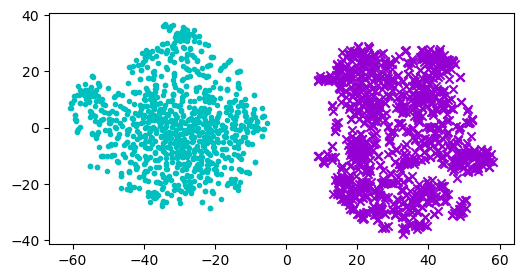

In [29]:
gendered_vectors = utils.extract_vectors(
    male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
precision 0.295


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
precision 0.713


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
precision 0.2635


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
precision 0.2705


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False
precision 0.7385


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True
precision 0.268


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False
precision 0.295


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True
precision 0.713


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False
precision 0.2635


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True
precision 0.2705


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False
precision 0.7385


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True
precision 0.268


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



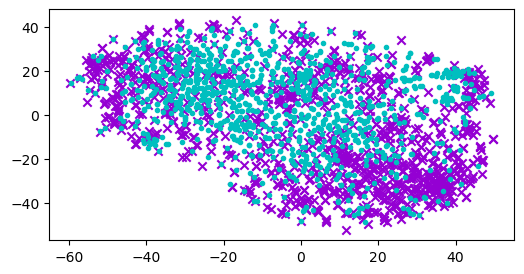

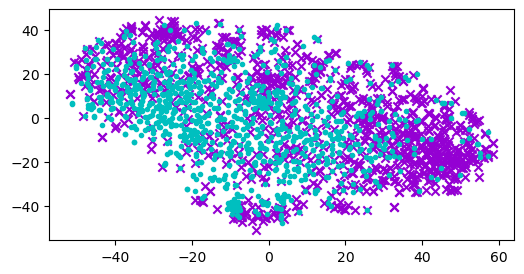

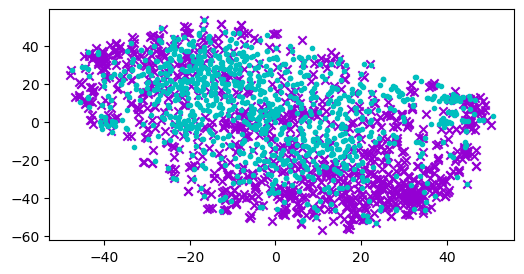

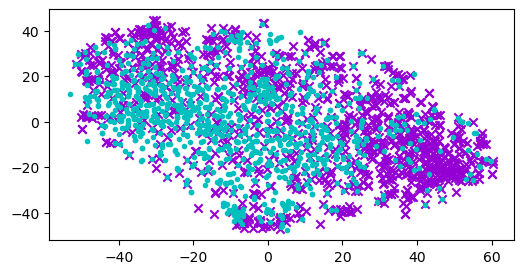

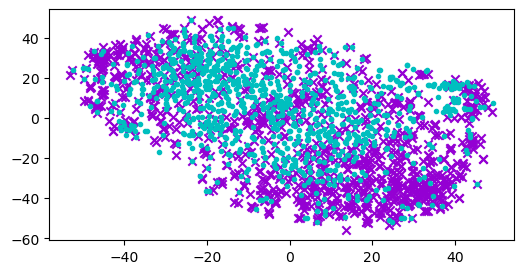

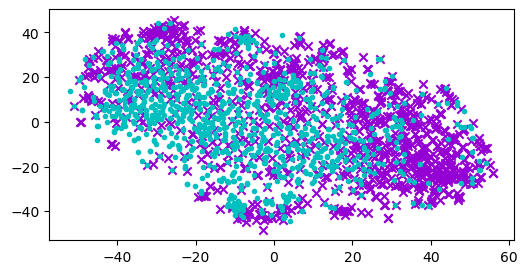

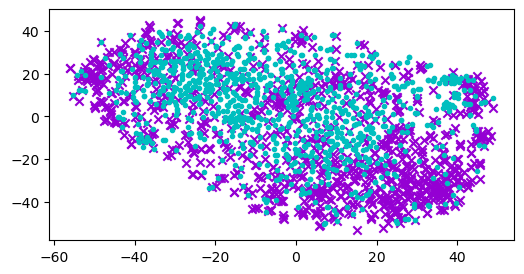

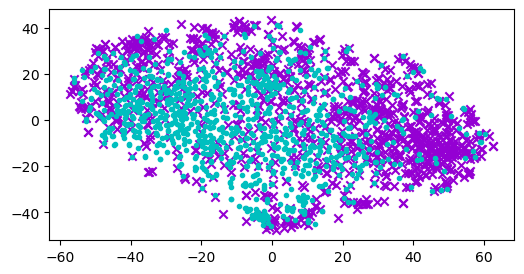

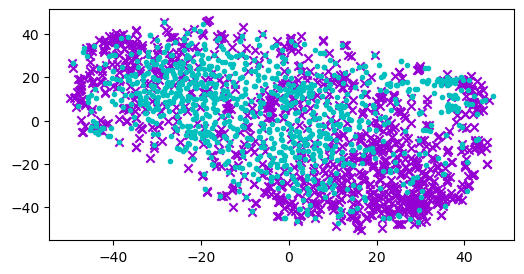

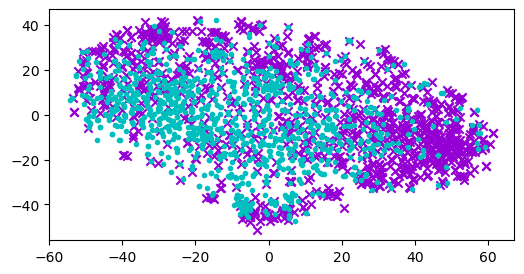

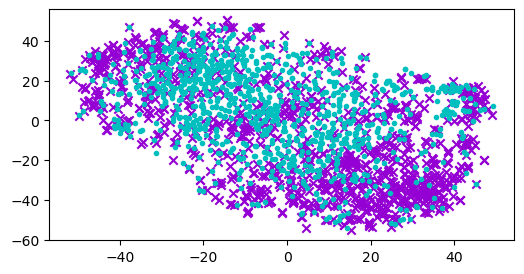

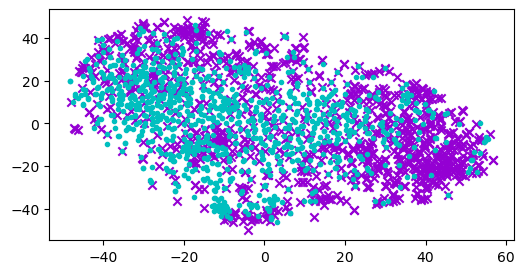

In [32]:
visualizing_all_clusters(grand_dict, parameters,
                         male_words + female_words, y_true)


### MAC Scores
The Mean Average Cosine Similarity (MAC) developed by Manzini et al. allows to quantify how big the bias removal was: the closer the score is to one, the largest, the removal. 

In [50]:
targets = [["he", "she"],
           ["his", "hers"],
           ["son", "daughter"],
           ["father", "mother"],
           ["male", "female"],
           ["boy", "girl"],
           ["uncle", "aunt"]]

Attributes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [51]:
def getting_all_mac_scores(grand_dict,parameters_df, dict_vec_cleaned, targets, Attributes): 
    mac_scores=[]
    originalMAC,originalDistribution = multiclass_evaluation_MAC(dict_vec_cleaned, targets, Attributes)
    print('Original MAC score:', originalMAC)
    mac_scores.append([originalMAC, originalDistribution])
    for i in range(len(parameters_df)):
        debiased_dict=grand_dict[i]['dict'] 
        debiasedMAC, debiasedDistribution = multiclass_evaluation_MAC(
                debiased_dict, targets, Attributes)
        mac_scores.append([debiasedMAC, debiasedDistribution])
        
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print('Debiased MAC score:', mac_scores[i+1][0])
    return mac_scores


In [53]:
mac_scores=getting_all_mac_scores(grand_dict,parameters, dict_vec_cleaned, targets, Attributes)

Original MAC score: 0.6051402024868171
Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
Debiased MAC score: 0.9996875067323269
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
Debiased MAC score: 0.9860507534142385
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
Debiased MAC score: 0.9906509475866638
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
Debiased MAC score: 0.9928985497303316
Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False
Debiased MAC score: 0.9997769820353867
Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True
Debiased MAC score: 0.9909766422354223
Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False
Debiased MAC score: 0.9996875029893053
Experiment_7 , normalize_direction: True , normalize_vectors: None , c

### Random Words Clusters
Although debiasing algorithms transform all the embedding vectors, rarely do they report changes in random words, here I explore the closest words to a random list of words (following Ravfogel). I then plot the original neighbors in the debiased embeddings to evaluate what happened to the original clusters

In [54]:
from collections import defaultdict
from sklearn.manifold import TSNE
import numpy as np
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [55]:
random_words


array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland'], dtype='<U18')

In [56]:
def get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)

    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 50)

        words_before_after=finding_neighbors_before_after(random_words, model_original, model_debiased, topn=topn)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print(words_before_after)
        


In [57]:
get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters, random_words, topn)

----------------------------------
word: clouds
 most-similar-before: ('cloud', 'mist', 'dust')
 most-similar-after: ('dprk', 'longtime', 'mps')
----------------------------------
word: italy
 most-similar-before: ('spain', 'italian', 'portugal')
 most-similar-after: ('best', 'trust', 'dead')
----------------------------------
word: anymore
 most-similar-before: ('else', 'everybody', 'you')
 most-similar-after: ('farms', 'christine', 'chaos')
----------------------------------
word: cardinals
 most-similar-before: ('mets', 'sox', 'orioles')
 most-similar-after: ('ahl', 'rushed', 'culminated')
----------------------------------
word: honest
 most-similar-before: ('thoughtful', 'absolutely', 'genuinely')
 most-similar-after: ('appearing', 'nicole', 'tally')
----------------------------------
word: eventual
 most-similar-before: ('securing', 'elimination', 'decisive')
 most-similar-after: ('mcintosh', 'lack', 'skinny')
----------------------------------
word: community
 most-similar-befor

In [58]:
def plot_random_words_clusters(parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)
    for i in range(len(parameters_df)):
        debiased_vectors = grand_dict[i]['vectors']
        debiased_vocab = grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(
            debiased_vectors, debiased_vocab, 50)
        
        #This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
        keys = random_words
        embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
            keys, model_original, model_debiased, topn)

        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                                init='pca', n_iter=3500, random_state=32)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        
        if i==0:
            tsne_plot_similar_words('Similar words before Debiasing',
                                keys, embeddings_en_2d, word_clusters, 0.7)


            tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)
        else:
            tsne_plot_similar_words('Similar words after Debiasing',
                                    keys, db_embeddings_en_2d, word_clusters, 0.7)


Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False


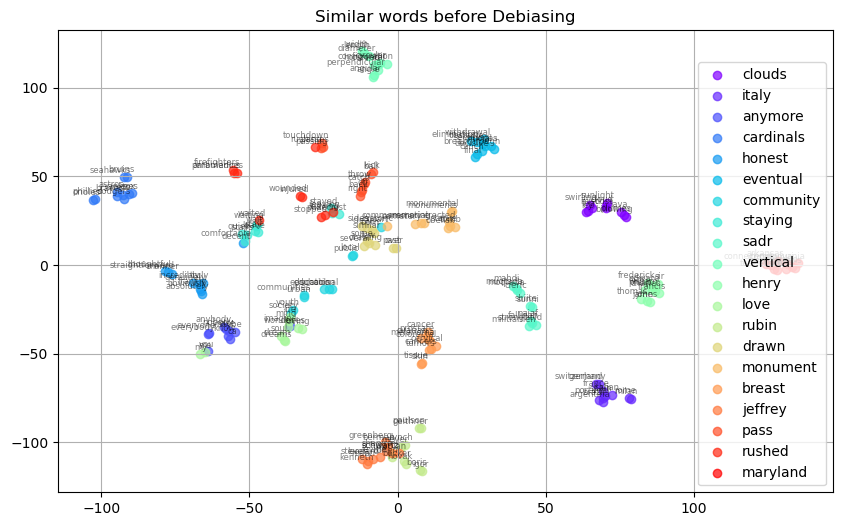

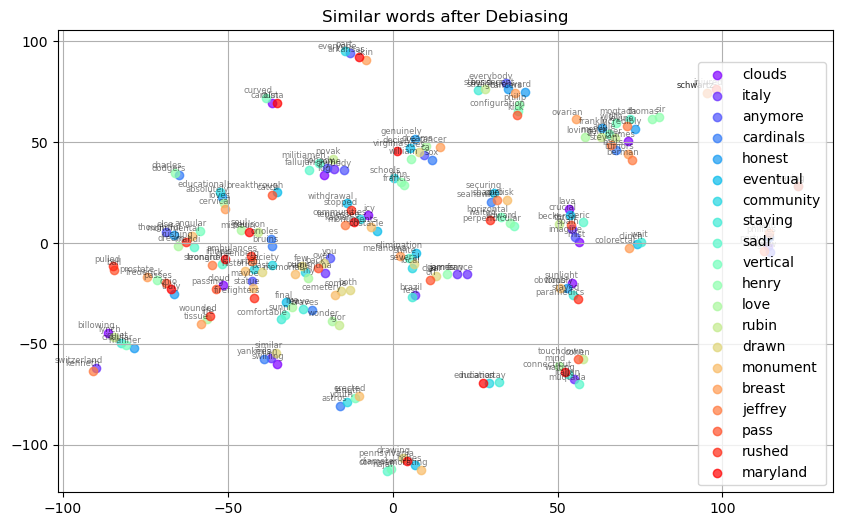

Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True


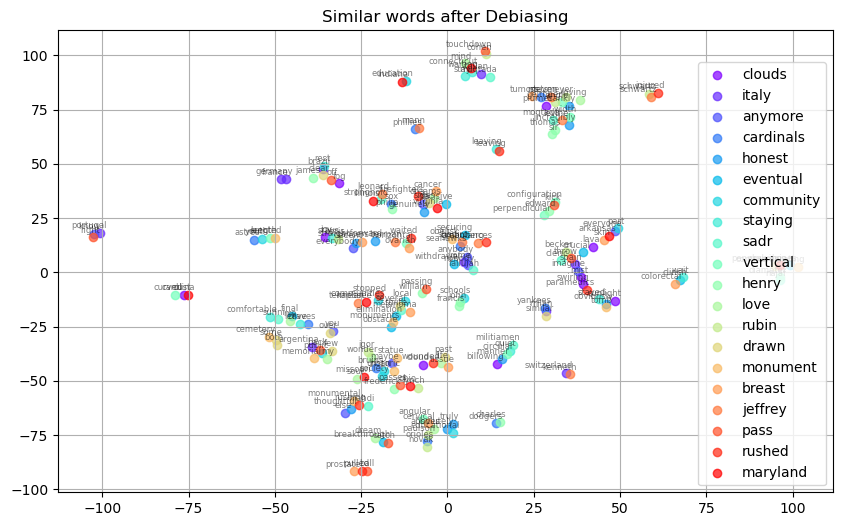

Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False


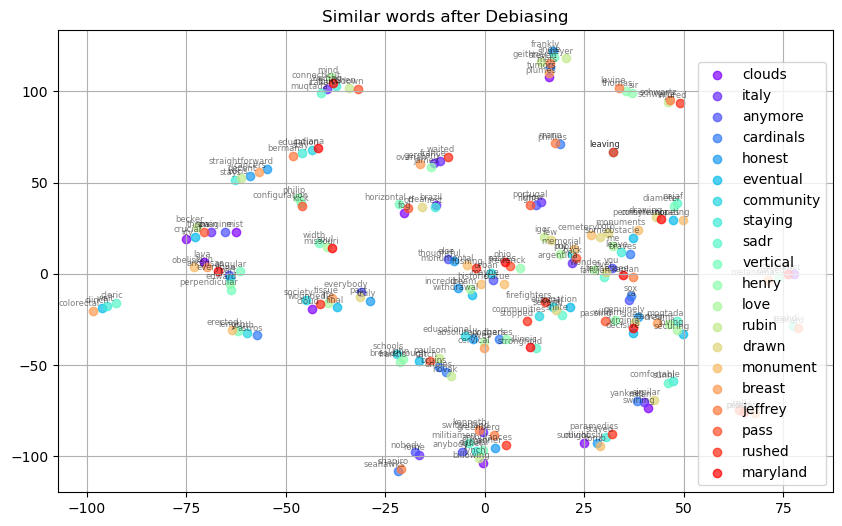

Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True


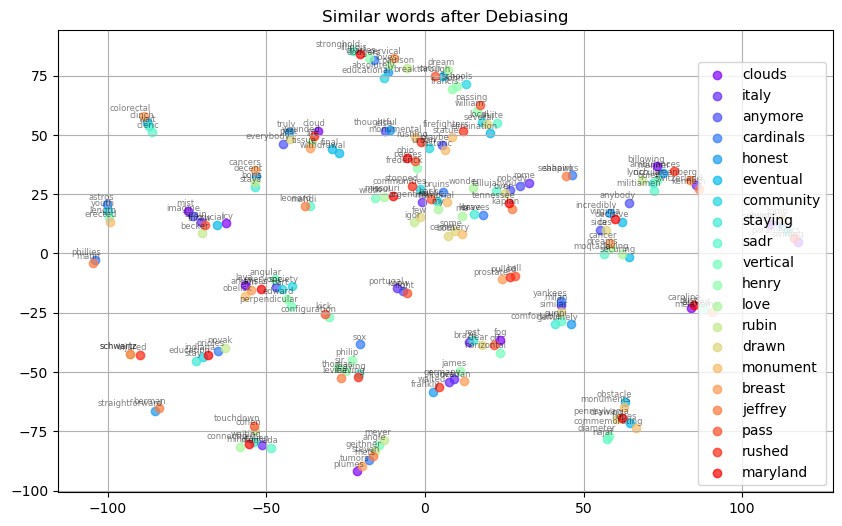

Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False


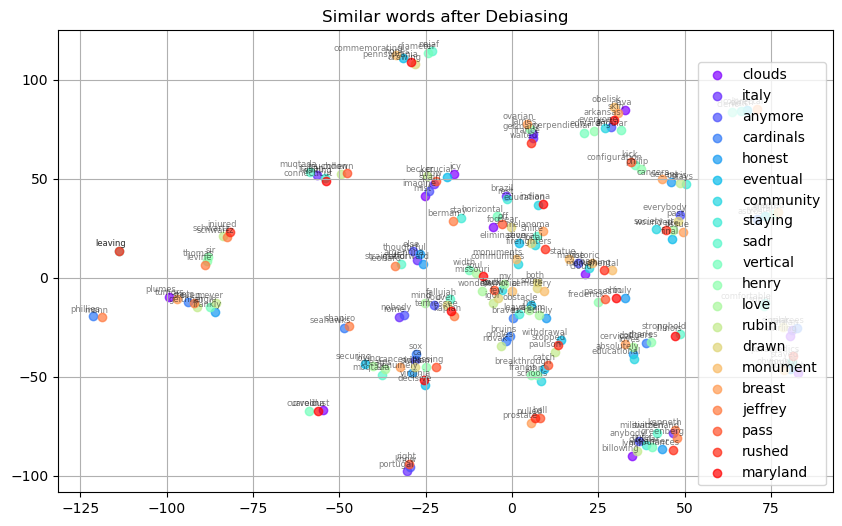

Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True


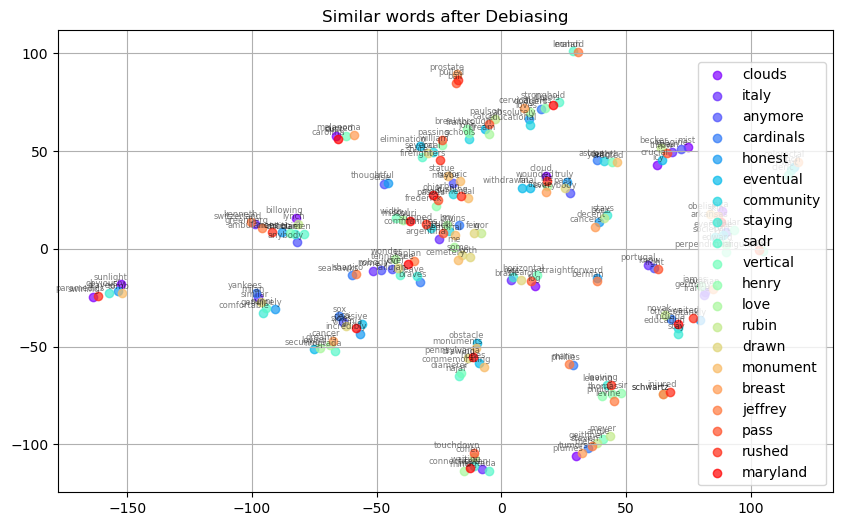

Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False


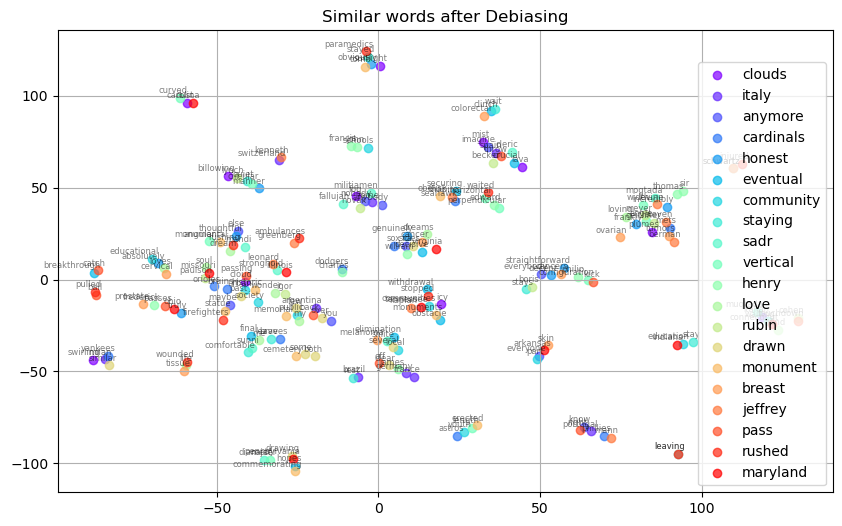

Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True


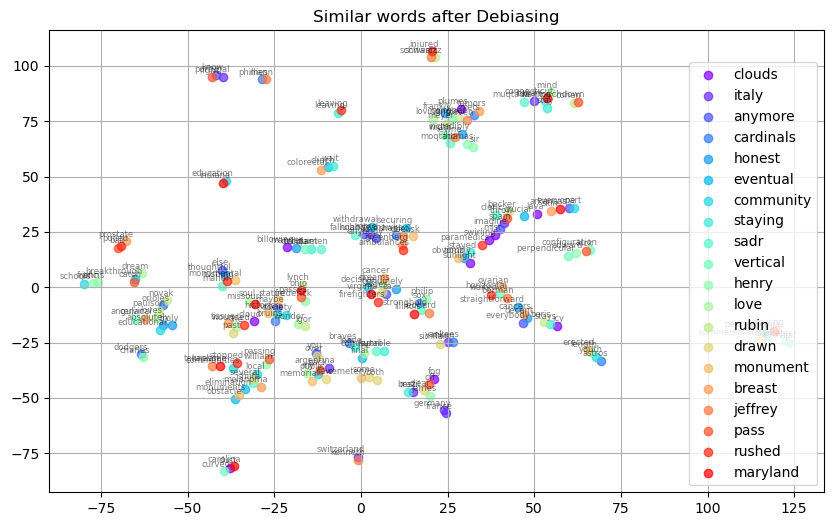

Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False


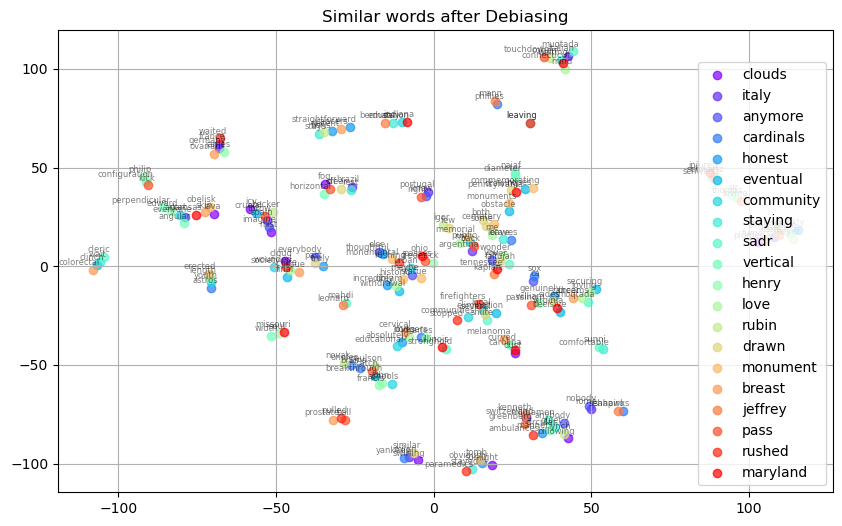

Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True


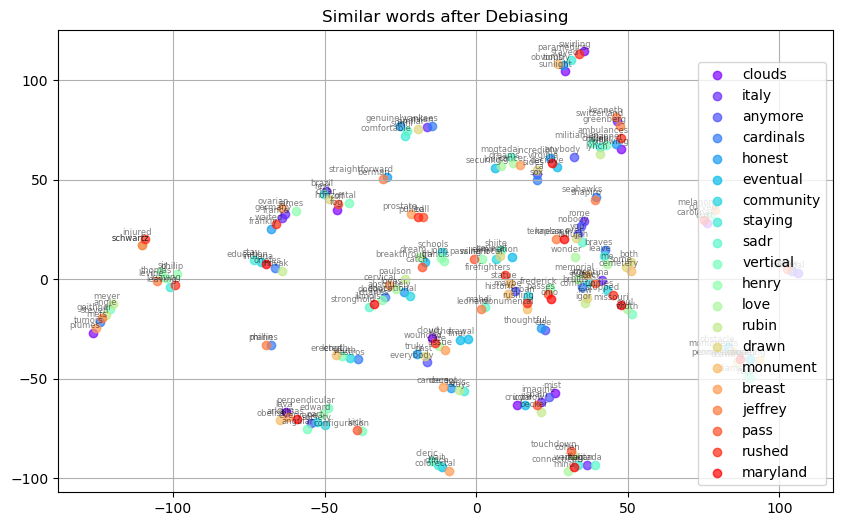

Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False


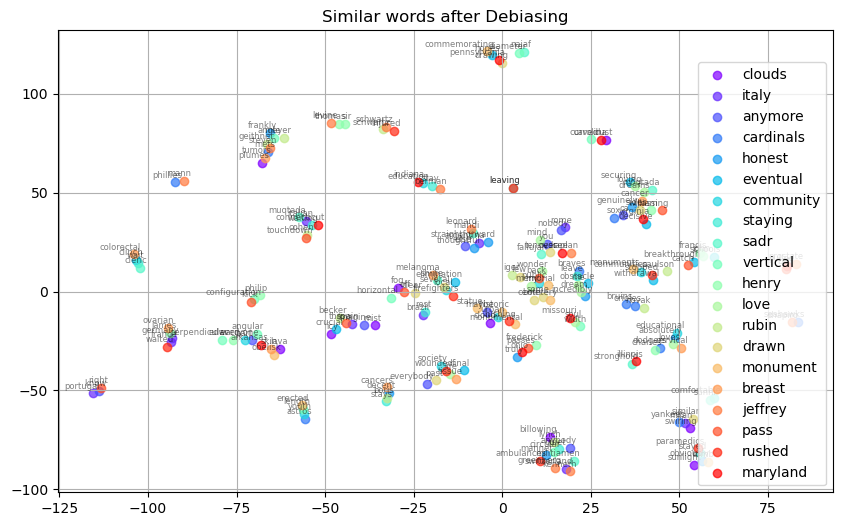

Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True


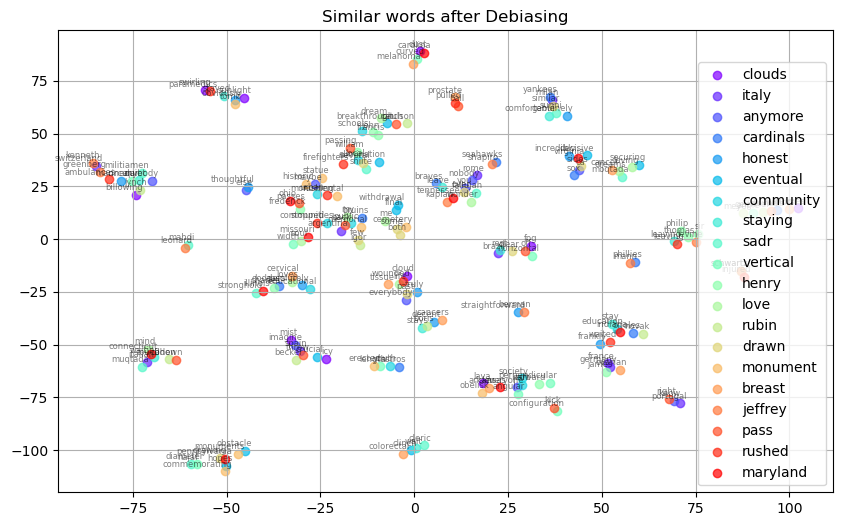

In [59]:
plot_random_words_clusters(parameters, random_words, 10)


### Bias-by-neighbor scores

In [ ]:
#### Bias by neighbor
c_w2i, c_vocab, female_words, male_words, y_true = getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)

biased_words = female_words+male_words


k_neighbors = finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)

#take k_neighbors dictionary and
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

